# <u>Chapter 6</u>: Teaching Machines to Translate

In [ ]:
import sys
import subprocess
import pkg_resources

# Find out which packages are missing.
installed_packages = {dist.key for dist in pkg_resources.working_set}
required_packages = {'numpy', 'tensorflow', 'pandas', 'keras'}
missing_packages = required_packages - installed_packages

# If there are missing packages install them.
if missing_packages:
    print('Installing the following packages: ' + str(missing_packages))
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing_packages], stdout=subprocess.DEVNULL)

In [33]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

import pandas as pd
import re

# Read the first 8K pairs in the dataset.
# Reduce the nrows parameter if there is a memory allocation problem.
data = pd.read_table('./data/fra.txt',  usecols=range(2), names=['source', 'target'], nrows=8000)

# Replace no-break and thin spaces in the target sentences.
data.target = data.target.apply(lambda x: re.sub(u'\xa0|\u202f|\u2009', u' ', x))
data.sample(5, random_state=123)

,source,target
5676,Tom is loyal.,Tom est fidèle.
617,I'm game.,J'en suis.
415,Back off!,Cassez-vous.
7687,Life is crazy.,La vie est dingue.
6708,I caused this.,J'ai causé ceci.


In [34]:
# Add two special tokens in the target sentences (start_of_stream/end_of_stream).
data['target'] = '<sos> ' + data['target'] + ' <eos>'
data.target[100]

'<sos> Je payai. <eos>'

In [35]:
# Extract the vocabulary of the source/target sentences.
src_voc = sorted(list(data['source'].str.split(' ', expand=True).stack().unique()))
trg_voc = sorted(list(data['target'].str.split(' ', expand=True).stack().unique()))

# Get the vocabulary size for the source/target sentences.
# Increase by one for the padding token.
src_voc_size = len(src_voc) + 1
trg_voc_size = len(trg_voc) + 1

print("Vocabulary size of the source sentences:", src_voc_size)
print("Vocabulary size of the target sentences:", trg_voc_size)

Vocabulary size of the source sentences: 2504
Vocabulary size of the target sentences: 4818


In [36]:
# Extract the maximum sentence length in the source/target sentences.
max_src_len = max([(len(s.split(' '))) for s in data['source']])
max_trg_len = max([(len(s.split(' '))) for s in data['target']])

print("Maximum length of the source sentences:", max_src_len)
print("Maximum length of the target sentences:", max_trg_len)

Maximum length of the source sentences: 5
Maximum length of the target sentences:: 12


In [37]:
# Create the word-to-index dictionary for the source/target tokens.
# Zero index reserved for the padding token.
src_word2idx = dict([(word, idx+1) for idx, word in enumerate(src_voc)])
trg_word2idx = dict([(word, idx+1) for idx, word in enumerate(trg_voc)])

print(trg_word2idx['Non'])

675


In [38]:
# Create the index-to-word dictionary for the source/target tokens.
src_idx2word = dict([(idx, word) for word, idx in src_word2idx.items()])
trg_idx2word = dict([(idx, word) for word, idx in trg_word2idx.items()])

print(trg_idx2word[675])

Non


In [39]:
import numpy as np

# The input/output data of the model.
enc_input_data = np.zeros((len(data['source']), max_src_len), dtype='float32')
dec_input_data = np.zeros((len(data['source']), max_trg_len), dtype='float32')
dec_output_data = np.zeros((len(data['source']), max_trg_len, trg_voc_size), dtype='float32')

# Iterate over the whole dataset.
for i, (src_sentence, trg_sentence) in enumerate(zip(data['source'], data['target'])):
    
    # Create the input for the encoder.
    for j, word in enumerate(src_sentence.split()):
        enc_input_data[i, j] = src_word2idx[word]
 
    # Create the input/output for the decoder.
    for j, word in enumerate(trg_sentence.split()):
        # Skip the '<eos>' word in the decoder input.
        if j < len(trg_sentence.split())-1:
            dec_input_data[i, j] = trg_word2idx[word]
        # Skip the '<sos>' word in the decoder output.
        if j > 0:
            dec_output_data[i, j-1, trg_word2idx[word]] = 1.0

In [40]:
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

# Create the input layers for the encoder/decoder.
enc_input = Input(shape=(None,), dtype='float32',)
dec_input = Input(shape=(None,), dtype='float32',)

# Create the embedding layers for the encoder/decoder.
embed_layer = Embedding(src_voc_size, 256, mask_zero=True)
enc_embed = embed_layer(enc_input)
embed_layer = Embedding(trg_voc_size, 256, mask_zero=True)
dec_embed = embed_layer(dec_input)

# Create the LSTM layers for the encoder/decoder.
enc_LSTM = LSTM(256, return_state=True)
_, state_h, state_c = enc_LSTM(enc_embed)
dec_LSTM = LSTM(256, return_state=True, return_sequences=True)
# The initial states of the decoder are the output from the encoder.
dec_output, _, _ = dec_LSTM(dec_embed, initial_state=[state_h, state_c])

# Create the output layer for the decoder.
dec_dense = Dense(trg_voc_size, activation='softmax')
dec_output = dec_dense(dec_output)

In [41]:
# Create and compile the model.
model = Model([enc_input, dec_input], dec_output)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()
model_params = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
print("Number of trainable parameters:", model_params)

Number of trainable parameters: 4163282


In [42]:
#print(model.summary())

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 256)    641024      ['input_7[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, None, 256)    1233408     ['input_8[0][0]']                
                                                                                            

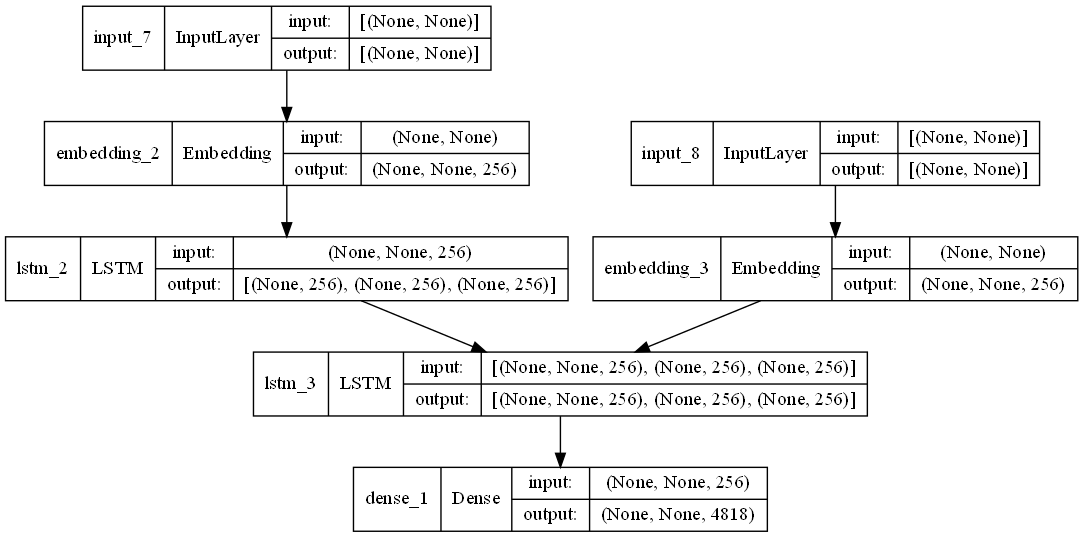

In [43]:
from keras.utils.vis_utils import plot_model

# Plot the model.
plot_model(model, to_file='./images/model_plot.png', show_shapes=True, show_layer_names=True, dpi=100)

In [44]:
# Fit the data to the model.
model.fit([enc_input_data, dec_input_data], dec_output_data,
            batch_size=128, epochs=100, validation_split=0.2, shuffle=False)

Epoch 1/100
50/50 [==============================] - 15s 176ms/step - loss: 2.0813 - accuracy: 0.2364 - val_loss: 2.1181 - val_accuracy: 0.2200
Epoch 2/100
50/50 [==============================] - 5s 105ms/step - loss: 1.7052 - accuracy: 0.2732 - val_loss: 2.0120 - val_accuracy: 0.2877
Epoch 3/100
50/50 [==============================] - 5s 104ms/step - loss: 1.5774 - accuracy: 0.2883 - val_loss: 1.9714 - val_accuracy: 0.3064
Epoch 4/100
50/50 [==============================] - 5s 105ms/step - loss: 1.4770 - accuracy: 0.3019 - val_loss: 1.9326 - val_accuracy: 0.3075
Epoch 5/100
50/50 [==============================] - 5s 103ms/step - loss: 1.4016 - accuracy: 0.3198 - val_loss: 1.9060 - val_accuracy: 0.3115
Epoch 6/100
50/50 [==============================] - 5s 104ms/step - loss: 1.3449 - accuracy: 0.3479 - val_loss: 1.9046 - val_accuracy: 0.3006
Epoch 7/100
50/50 [==============================] - 5s 104ms/step - loss: 1.2949 - accuracy: 0.3722 - val_loss: 1.8852 - val_accuracy: 0.328

Inference phase

In [50]:
# Model to encode the input.
enc_model = Model(enc_input, [state_h, state_c])

# The hidden and cell states of the decoder at each step.
dec_state_in_h = Input(shape=(256,))
dec_state_in_c = Input(shape=(256,))

# Set the embedding layer.
dec_embed_2 = embed_layer(dec_input)

# Set the LSTM layer.
dec_output_2, dec_state_out_h, dec_state_out_c = dec_LSTM(dec_embed_2, initial_state=[dec_state_in_h, dec_state_in_c])

# Set the output layer for the decoder.
dec_output_2 = dec_dense(dec_output_2)

# Create the decoder model.
decoder_model = Model([dec_input] + [dec_state_in_h, dec_state_in_c],
                        [dec_output_2] + [dec_state_out_h, dec_state_out_c])

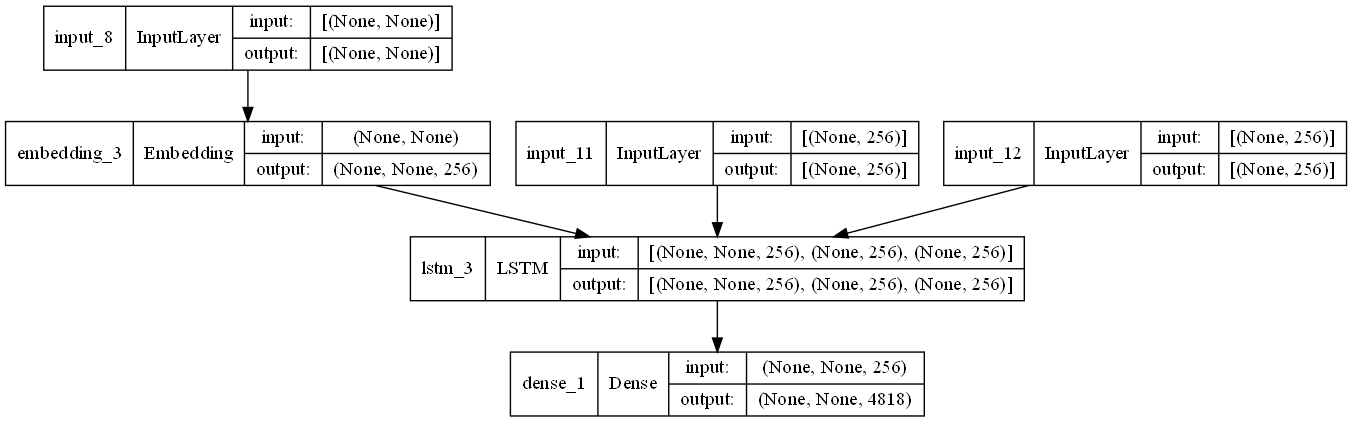

In [51]:
# Plot the model.
plot_model(decoder_model, to_file='./images/inference_model_plot.png', show_shapes=True, show_layer_names=True, dpi=100)

In [52]:
# Translate an input sentence.
def getTranslation(index):

    translation = word = ''

    # Choose randomly a sequence from the data set.
    #i = np.random.choice(len(data['source']))

    # Choose a sequence from the data set.
    source_seq = enc_input_data[index:index+1]

    # Get the initial input states for the decoder.
    states_h_c = enc_model.predict(source_seq)

    # The first input token to the decoder is start_of_stream.
    token = np.zeros((1,1))
    token[0, 0] = trg_word2idx['<sos>']

    # Start the decoding process.
    while (word != '<eos>' and len(translation) <= 100):

        # Predict the next token and states.
        output, state_h, state_c = decoder_model.predict([token] + states_h_c)
        
        # Store the emitted token and the states for the next iteration.
        idx = np.argmax(output[0, -1, :])
        token[0, 0] = idx
        states_h_c = [state_h, state_c]

        # Extract the emitted word.
        word = trg_idx2word[idx]
        translation += ' ' + word

    return translation

In [48]:
print("Input sentence:", data['source'][1308])
print("Reference translation:", data['target'][1308].replace("<sos>","").replace("<eos>",""))
print("Hypothesis:", getTranslation(1308)[:-6])

Input sentence: Seriously?
Reference translation:  C'est vrai ? 
Hypothesis:  Vraiment ?


In [53]:
from nltk.translate.bleu_score import sentence_bleu

hypothesis = getTranslation(1006)[:-6].split()
reference = data['target'][1006].replace("<sos>","").replace("<eos>","").split()

# Calculate the BLEU score.
bleu = sentence_bleu([reference], hypothesis, weights=(1, 1, 1))

print("Input sentence:", data['source'][1006])
print("Reference translation:", reference)
print("Hypothesis:", hypothesis)
print("BLEU score:", bleu)

Input sentence: I relaxed.
Reference translation: ['Je', 'me', 'suis', 'détendue.']
Hypothesis: ['Je', 'me', 'suis', 'détendu.']
BLUE score: 0.25


### Machine Learning Techniques for Text 
&copy;2022&ndash;2023, Nikos Tsourakis, <nikos@tsourakis.net>, Packt Publications. All Rights Reserved.